## Descripción del proyecto

Al un operador de telecomunicaciones le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario planea irse, se le ofrecerán códigos promocionales. El equipo ha recopilado algunos de los datos personales de sus clientes, y hay que predecir cuando un usuario se piensa salir.


In [ ]:
# Importamos todas las librerías necesarias para el proyecto

import pandas as pd
import numpy as np
from scipy.stats import randint, uniform
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score



In [ ]:
#Cargamos los dataframes previamente realizados
'''
df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
df_phone = pd.read_csv('/datasets/final_provider/phone.csv')
'''

df_contract = pd.read_csv('/content/contract.csv')
df_personal = pd.read_csv('/content/personal.csv')
df_internet = pd.read_csv('/content/internet.csv')
df_phone = pd.read_csv('/content/phone.csv')

### 1. Revisión de datasets

Primero inspeccionemos los dataframes para saber que acciones tomar con ellos.

In [ ]:
df_interconect = [df_contract, df_personal, df_internet, df_phone]

for df in df_interconect:
    print('Data frame')
    print(df.head())

Data frame
   customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes               Mailed check           53.85       108.15  
3               No  Bank transfer (automatic)           42.30      1840.75  
4              Yes           Electronic check           70.70       151.65  
Data frame
   customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575

In [ ]:
df_interconect = [df_contract, df_personal, df_internet, df_phone]

for df in df_interconect:
    print('Data frame')
    df.info()
    print(df.describe())
    print(f'Existen {df.duplicated().sum()} duplicados')
    print(df.isna().sum())
    print()

Data frame
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
       MonthlyCharges
count     7043.000000
mean        64.761692
std         30.090047
min         18.250000
25%         35.500000
50%         70.350000
75%         89.850000
max        118.750000
Existen 0 duplicados
customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyC

Procederemos a editar los dataframes para su análisis, cambiano los nombres de las columnas, alguos tipos de datos y rellenando los valores negativos.


In [ ]:
# Formatear las columnas

def to_snake_case(name):
    import re
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    name = re.sub('__([A-Z])', r'_\1', name)
    name = re.sub('([a-z0-9])([A-Z])', r'\1_\2', name).lower()
    return name

dfs = [df_contract, df_personal, df_internet, df_phone]
df_names = ['df_contract', 'df_personal', 'df_internet', 'df_phone']

for df, name in zip(dfs, df_names):
    df.columns = [to_snake_case(col) for col in df.columns]


In [ ]:
#Corrigiendo los tipos de valores

df_contract['begin_date'] = pd.to_datetime(df_contract['begin_date'])
df_contract['end_date'] = pd.to_datetime(df_contract['end_date'], errors='coerce')
df_contract['total_charges'] = pd.to_numeric(df_contract['total_charges'], errors='coerce')


print("Información del DataFrame df_contract después de la conversión de fechas:")
df_contract.info()

Información del DataFrame df_contract después de la conversión de fechas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


/tmp/ipython-input-2865311084.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_contract['end_date'] = pd.to_datetime(df_contract['end_date'], errors='coerce')


In [ ]:
# Juntando los dataframes en customer_id
df_merged = df_contract.merge(df_personal, on='customer_id', how='left')
df_merged = df_merged.merge(df_internet, on='customer_id', how='left')
df_merged = df_merged.merge(df_phone, on='customer_id', how='left')

#
df_merged['end_date'] = df_merged['end_date'].apply(lambda x: 'Yes' if pd.notna(x) else 'No')

# Columnas con nan para rellenar
internet_related_cols = ['internet_service', 'online_security', 'online_backup',
                        'device_protection', 'tech_support', 'streaming_tv',
                        'streaming_movies','multiple_lines']

# Imputar con "No" para indicar que no tienen estos servicios
df_merged[internet_related_cols] = df_merged[internet_related_cols].fillna('No')

#Eliminamos las 11 filas con valor ausente
df_merged = df_merged.dropna(subset=['total_charges'])

print("DataFrame fusionado:")
print(df_merged.head())

print("Información del DataFrame fusionado:")
df_merged.info()

DataFrame fusionado:
  customer_id begin_date end_date            type paperless_billing  \
0  7590-VHVEG 2020-01-01       No  Month-to-month               Yes   
1  5575-GNVDE 2017-04-01       No        One year                No   
2  3668-QPYBK 2019-10-01      Yes  Month-to-month               Yes   
3  7795-CFOCW 2016-05-01       No        One year                No   
4  9237-HQITU 2019-09-01      Yes  Month-to-month               Yes   

              payment_method  monthly_charges  total_charges  gender  \
0           Electronic check            29.85          29.85  Female   
1               Mailed check            56.95        1889.50    Male   
2               Mailed check            53.85         108.15    Male   
3  Bank transfer (automatic)            42.30        1840.75    Male   
4           Electronic check            70.70         151.65  Female   

   senior_citizen partner dependents internet_service online_security  \
0               0     Yes         No          

### 2. Analisis Exploratorio.

Ya realizamos el dataframe  'df_merge' que contiene toda la informacion para nuestro analisis y posterios entrenamiento.

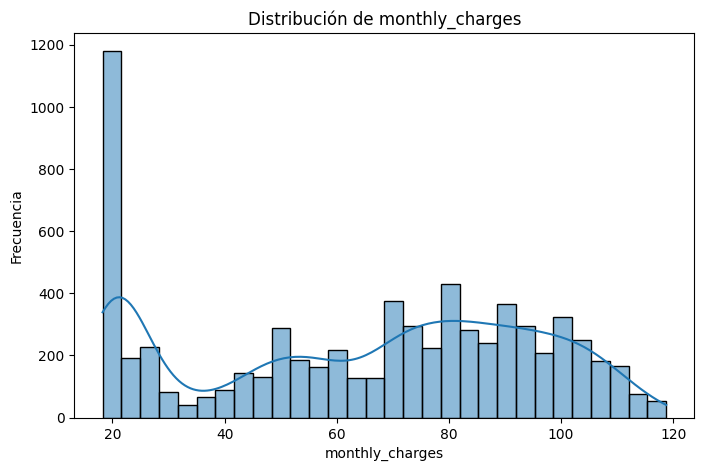

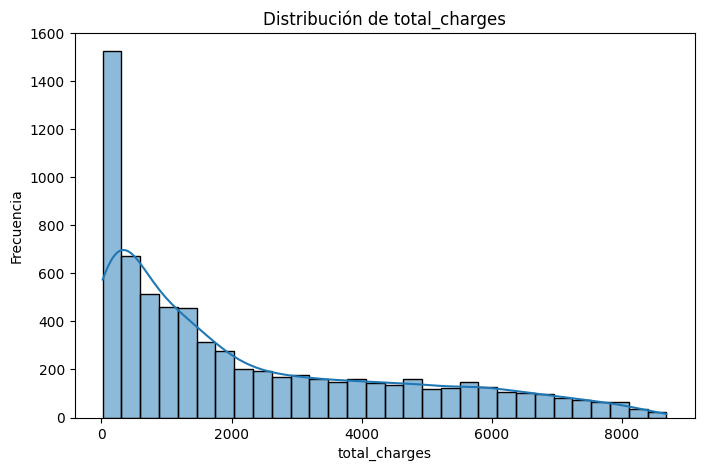

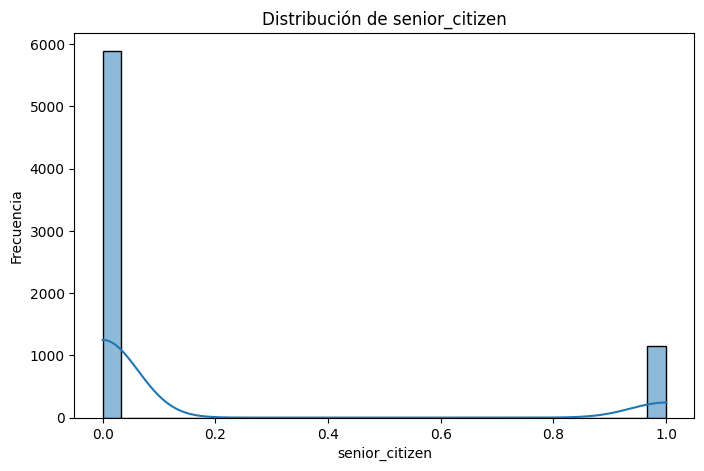

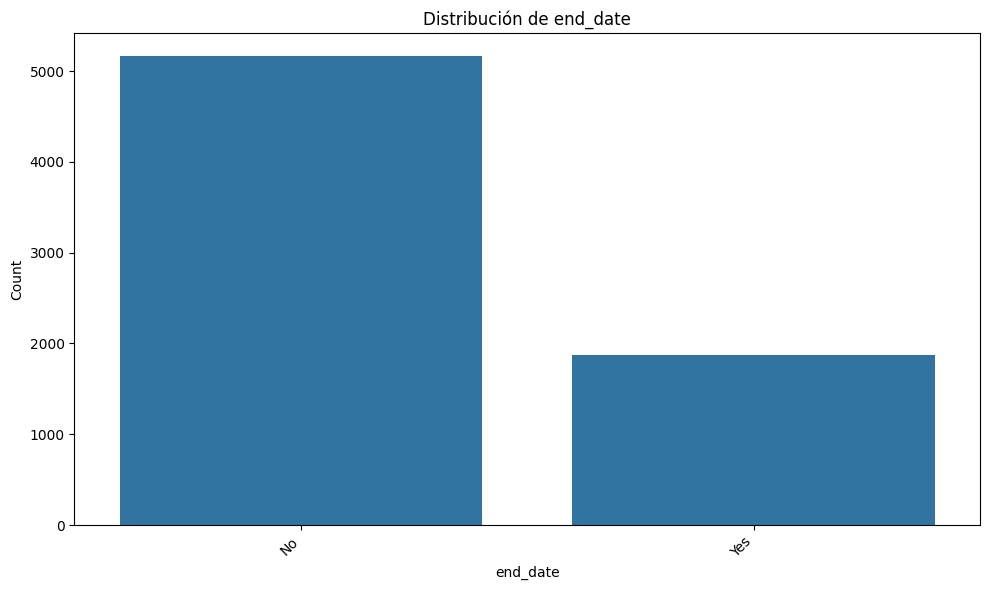

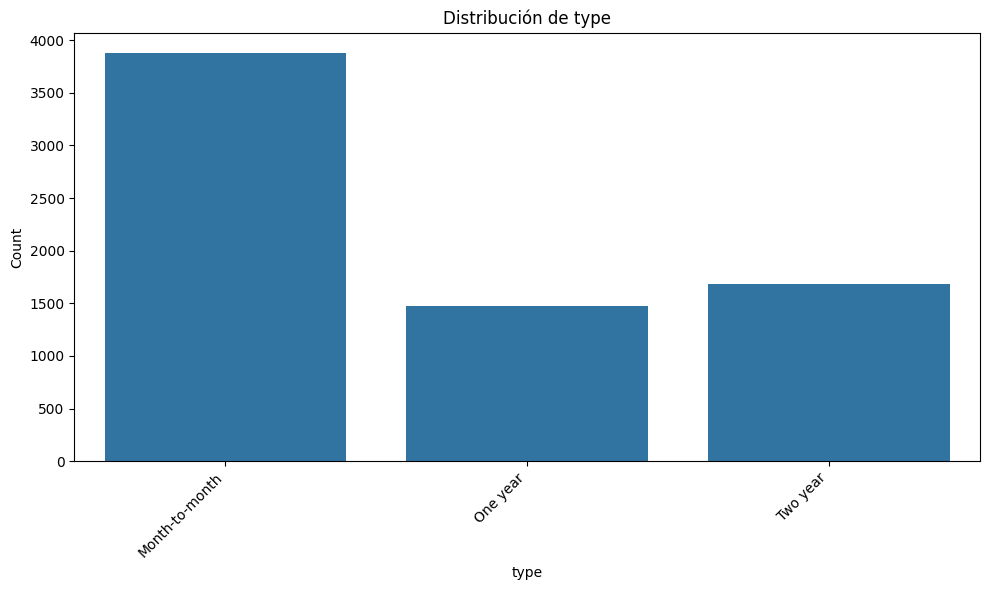

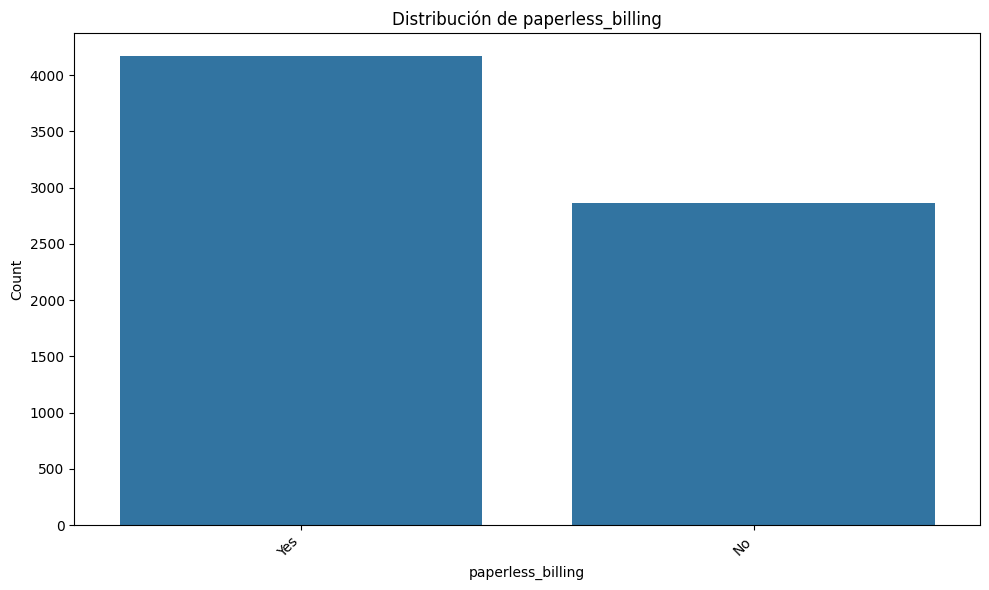

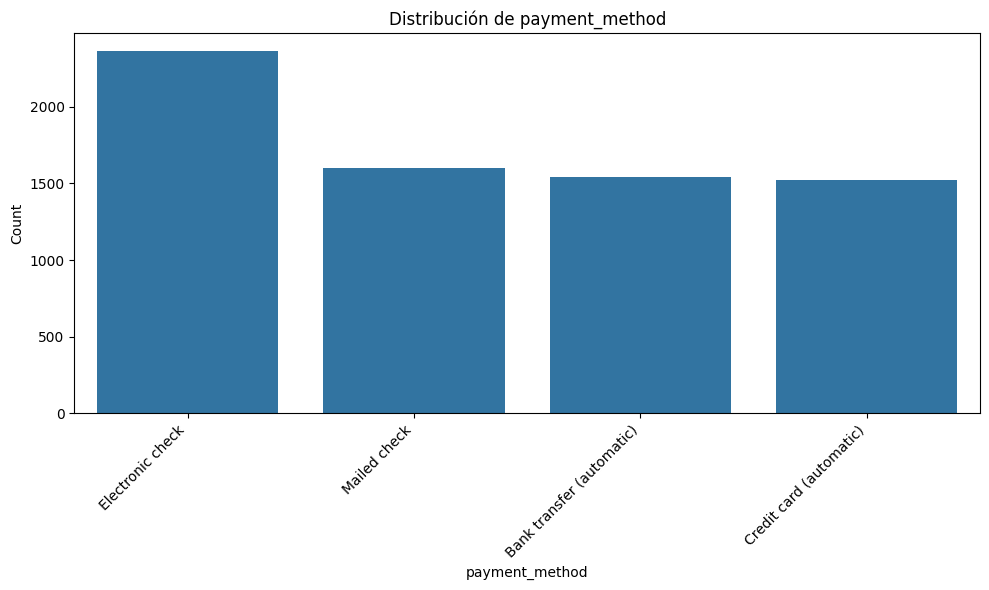

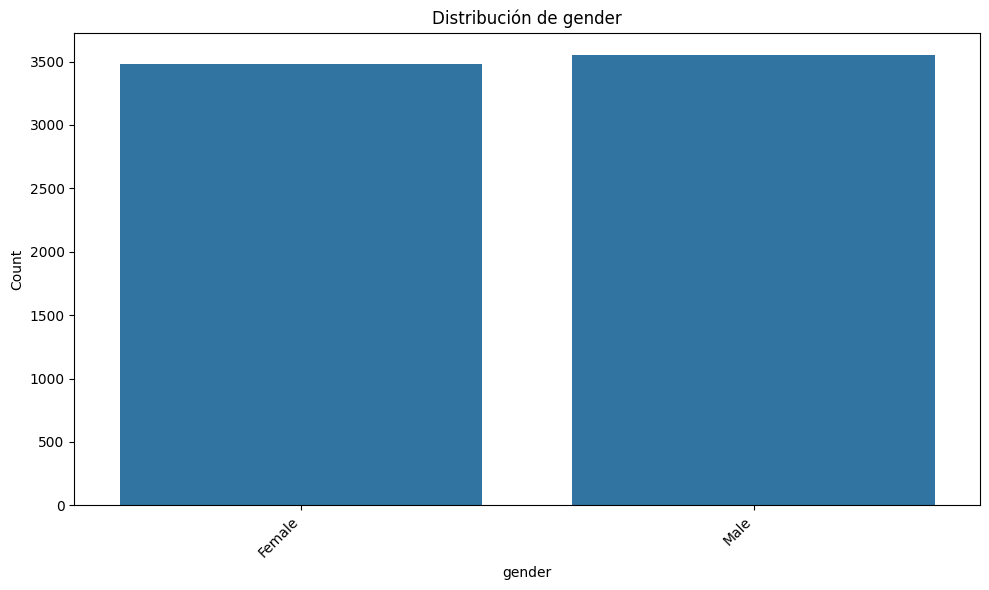

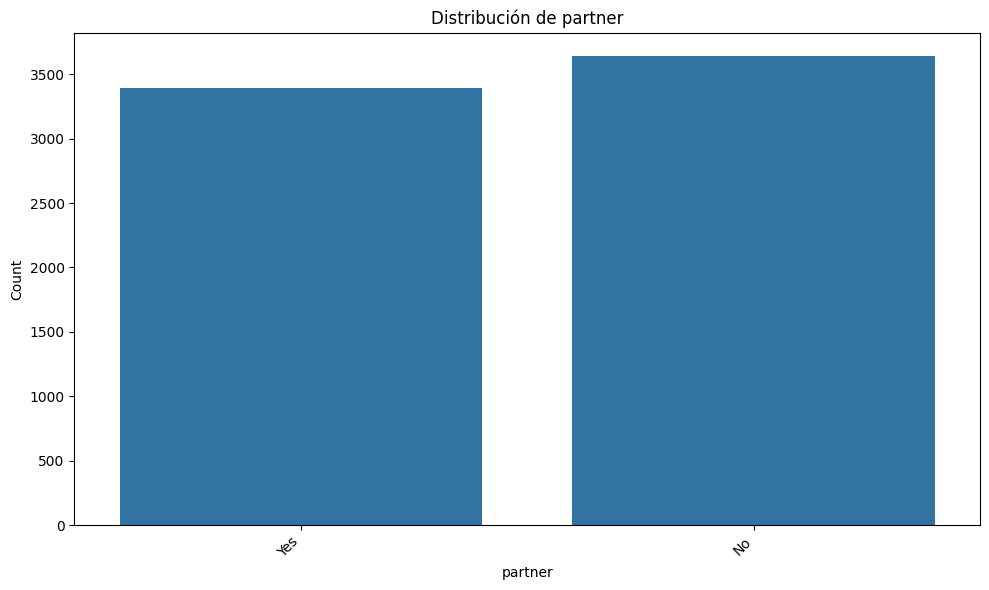

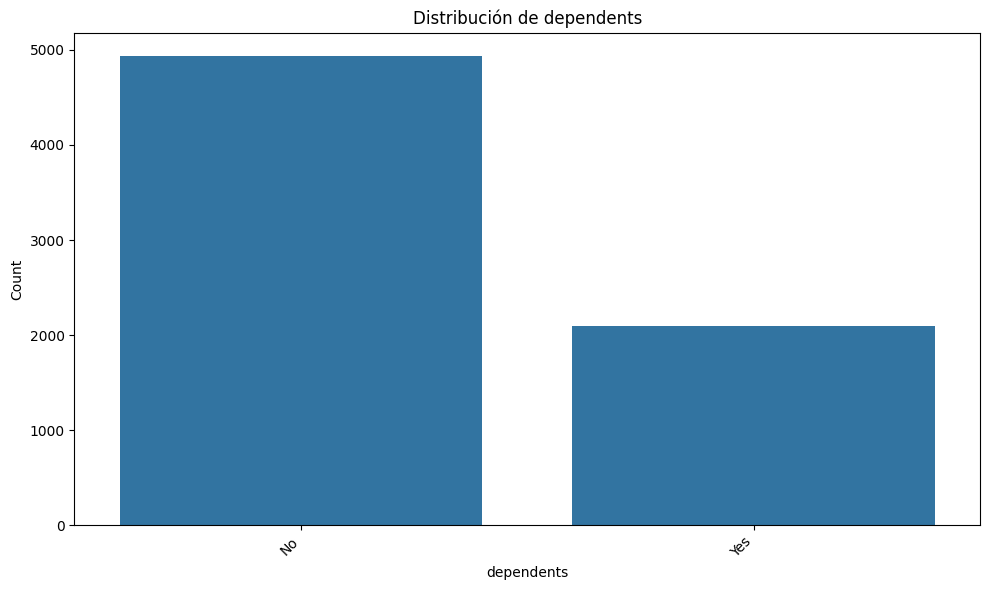

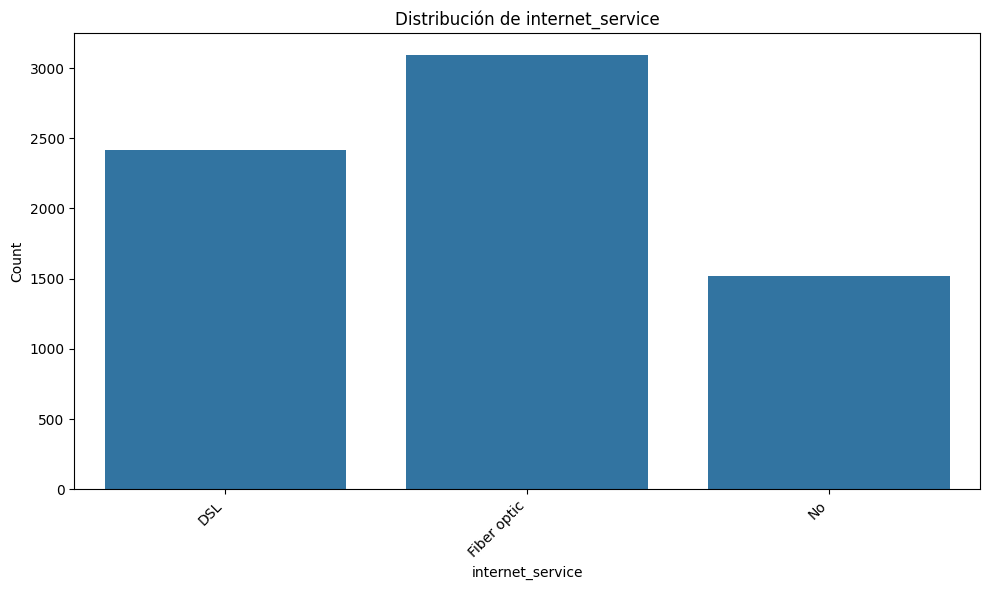

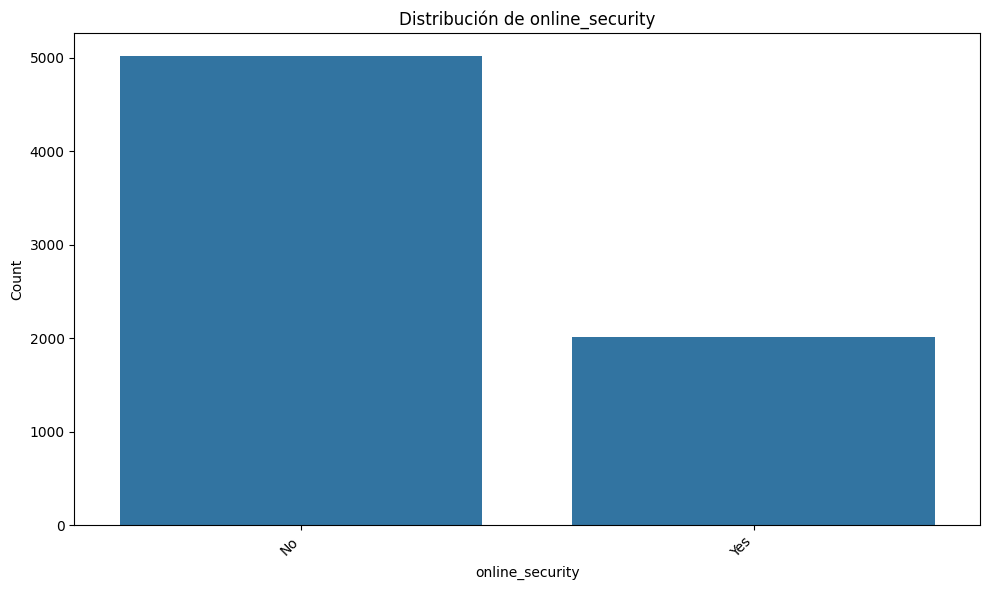

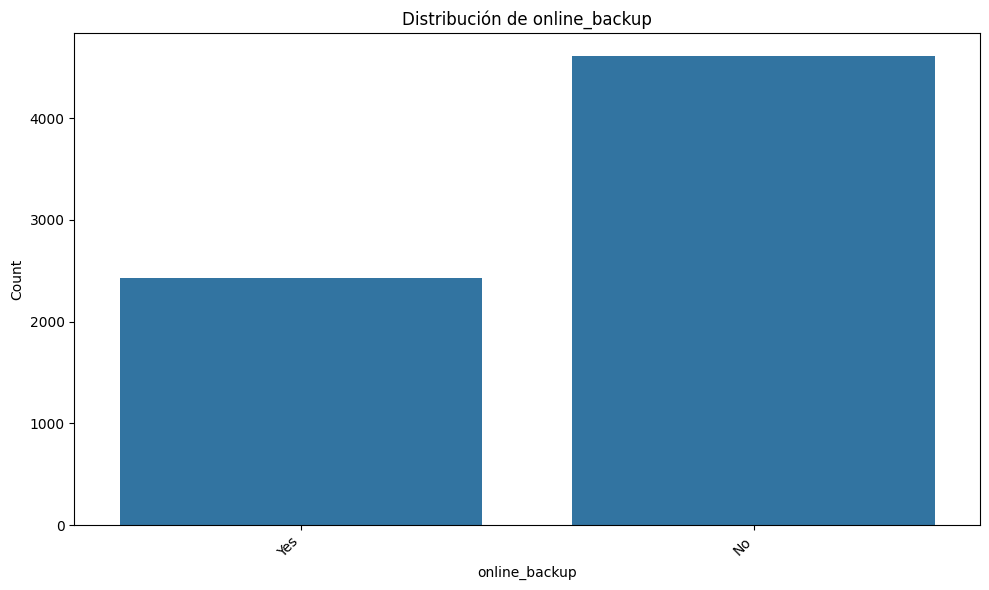

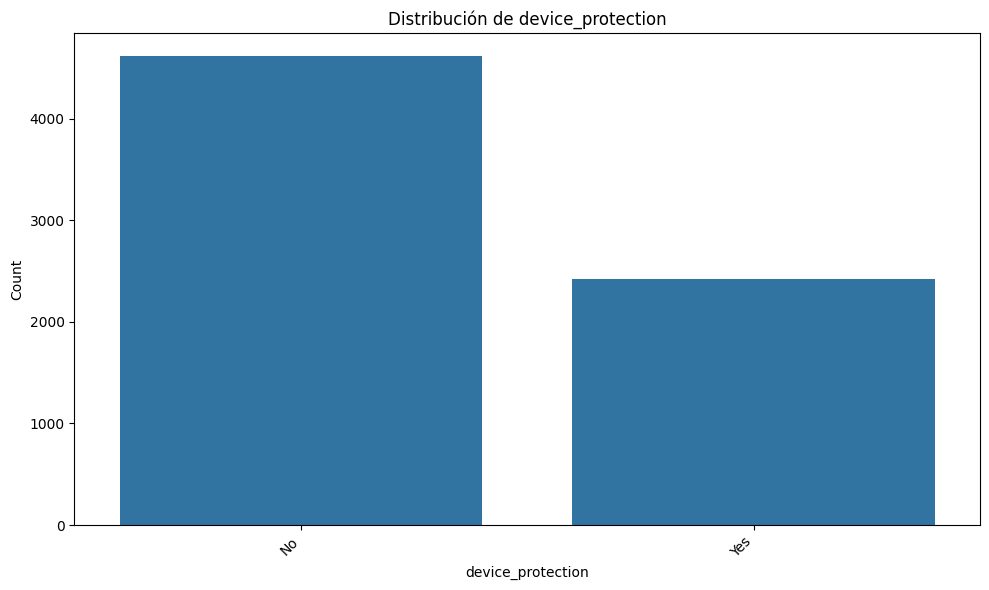

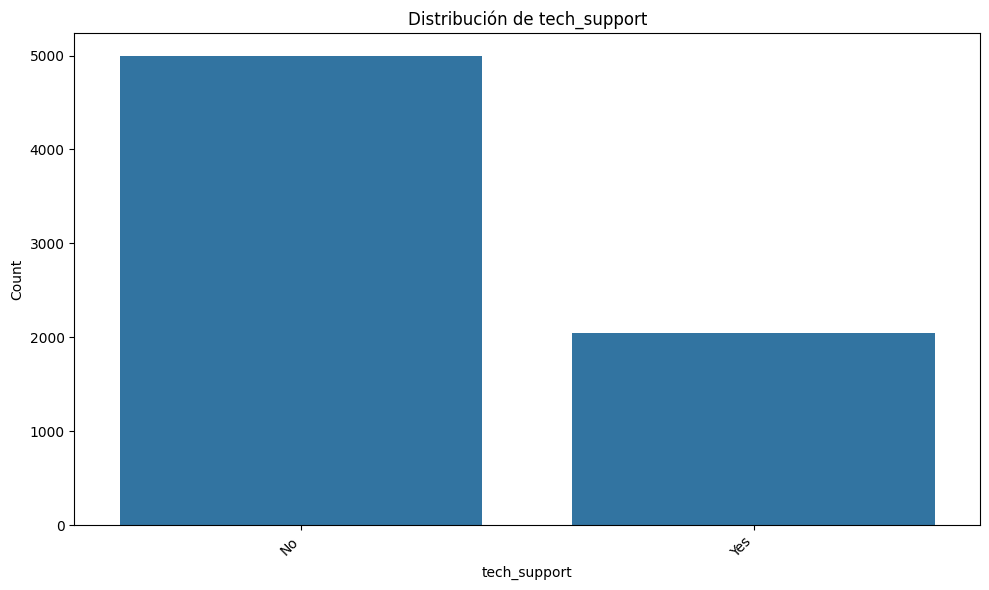

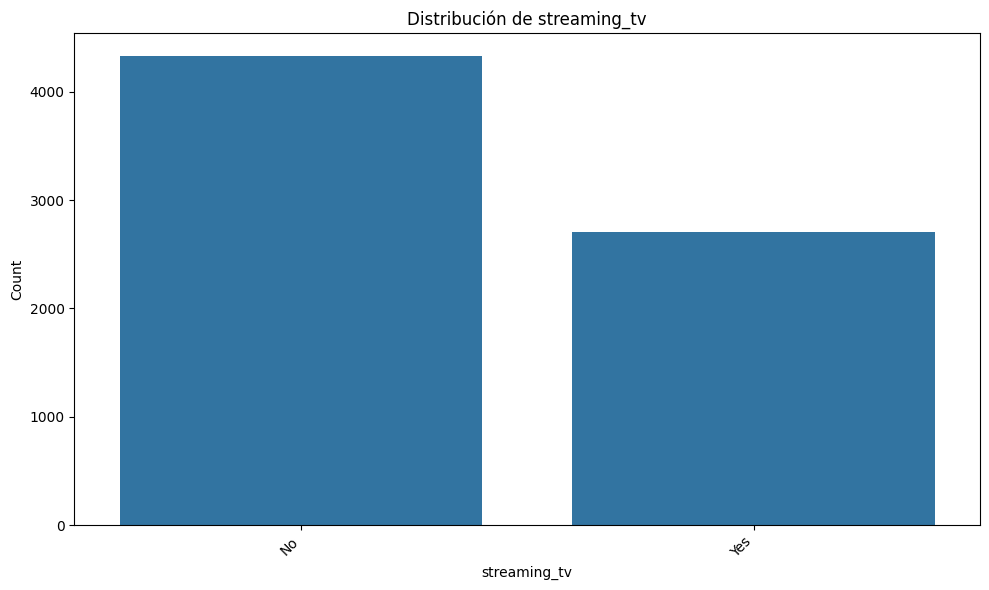

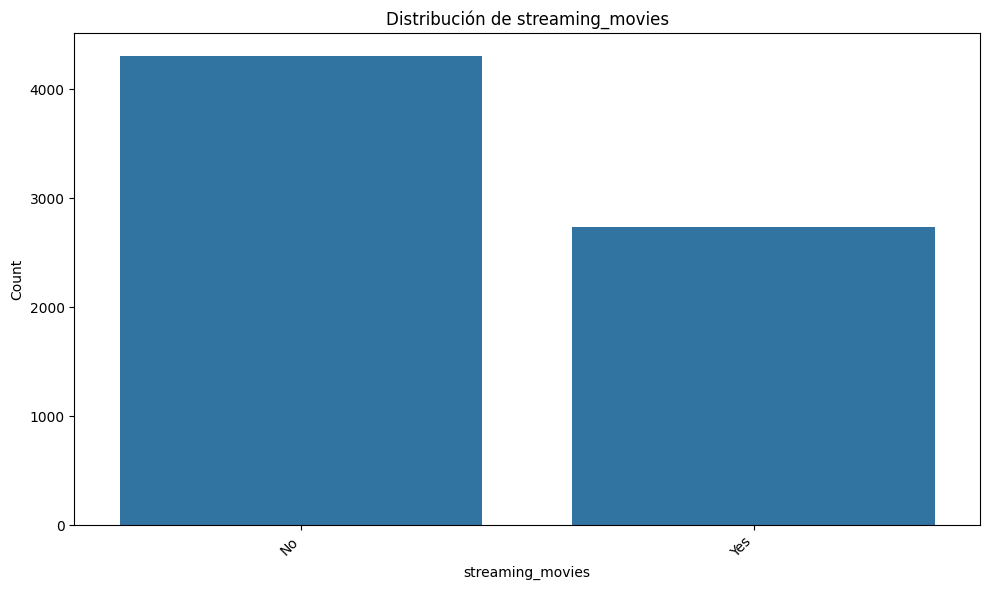

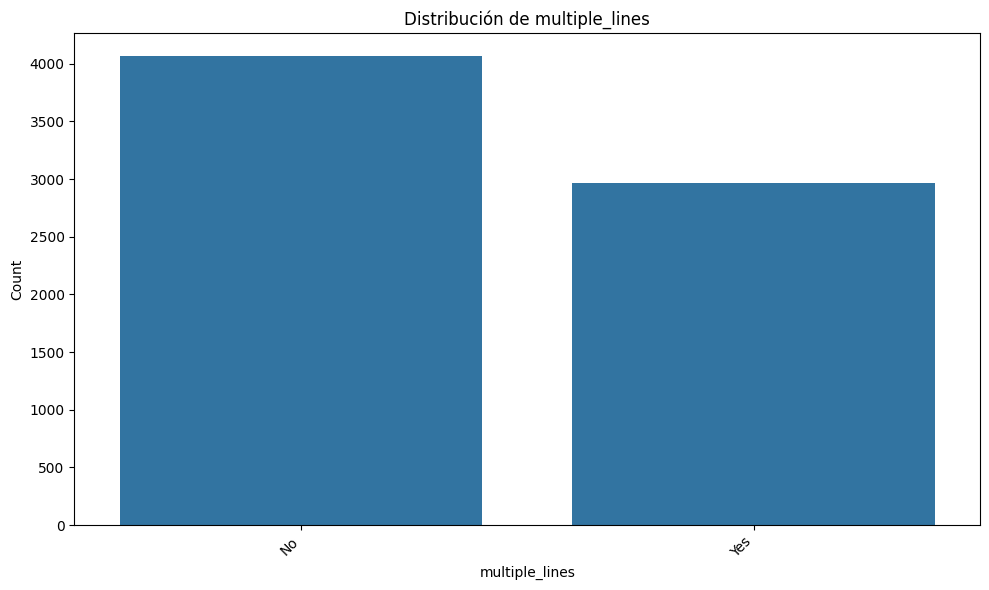

In [ ]:
#dividimos nuestras columnas en numericas y categoricas
numerical_cols = df_merged.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df_merged.select_dtypes(include='object').columns.tolist()
categorical_cols.remove('customer_id') #Quitar customer_id

# Graficando columnas numericas
for col in numerical_cols:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df_merged, x=col, bins=30, kde=True)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.show()

# Gráficando columnas categóricas
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df_merged, x=col)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

En la mayoria de las categorias los pesos no estan equilibrados, ni las distribuciones son normales, habra que hacer una comparación con nuestra variable objetivo.

tabla de contingencia para type vs Objetivo:


end_date,No,Yes
type,,
Month-to-month,2220,1655
One year,1306,166
Two year,1637,48


tabla de porcentaje para type vs Objetivo:


end_date,No,Yes
type,,
Month-to-month,57.290323,42.709677
One year,88.722826,11.277174
Two year,97.151335,2.848665


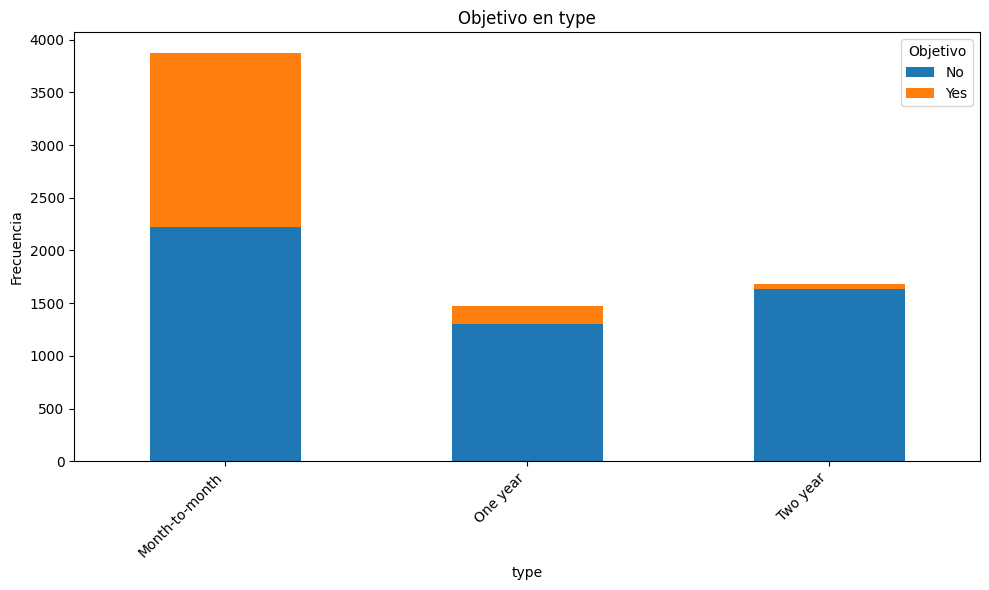

tabla de contingencia para paperless_billing vs Objetivo:


end_date,No,Yes
paperless_billing,,
No,2395,469
Yes,2768,1400


tabla de porcentaje para paperless_billing vs Objetivo:


end_date,No,Yes
paperless_billing,,
No,83.624302,16.375698
Yes,66.410749,33.589251


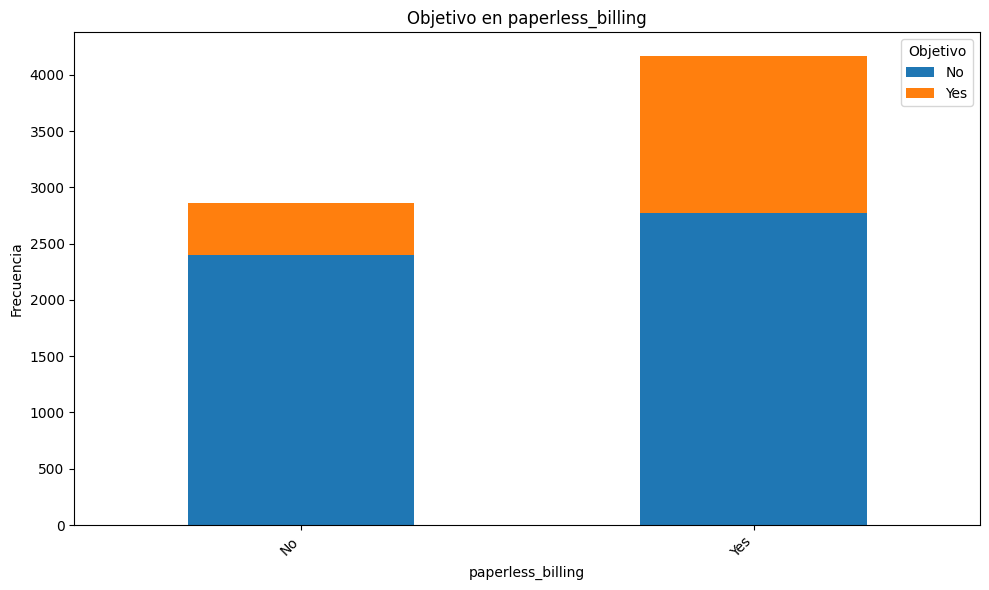

tabla de contingencia para payment_method vs Objetivo:


end_date,No,Yes
payment_method,,
Bank transfer (automatic),1284,258
Credit card (automatic),1289,232
Electronic check,1294,1071
Mailed check,1296,308


tabla de porcentaje para payment_method vs Objetivo:


end_date,No,Yes
payment_method,,
Bank transfer (automatic),83.268482,16.731518
Credit card (automatic),84.746877,15.253123
Electronic check,54.714588,45.285412
Mailed check,80.798005,19.201995


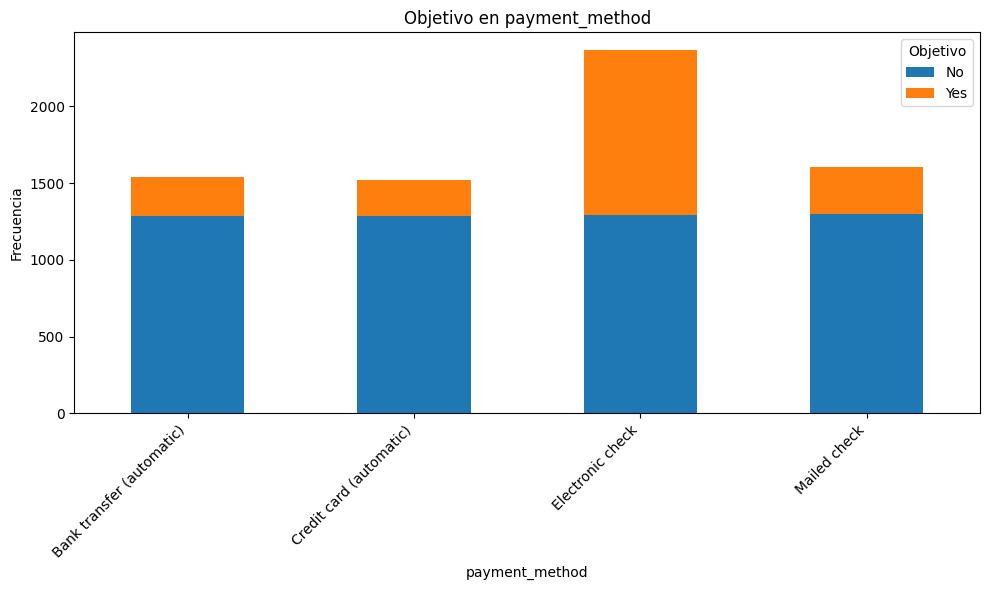

tabla de contingencia para gender vs Objetivo:


end_date,No,Yes
gender,,
Female,2544,939
Male,2619,930


tabla de porcentaje para gender vs Objetivo:


end_date,No,Yes
gender,,
Female,73.040482,26.959518
Male,73.795435,26.204565


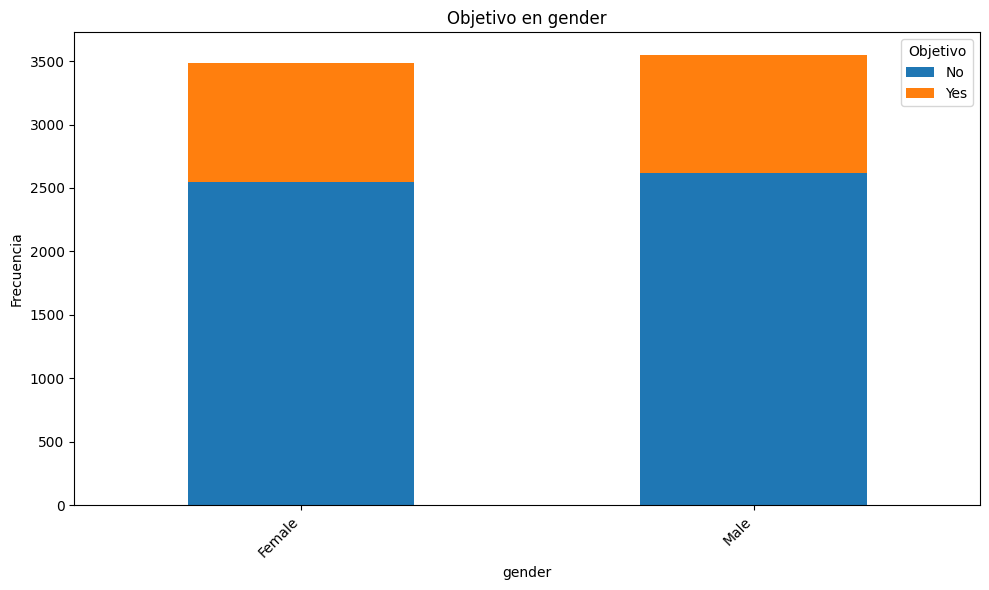

tabla de contingencia para partner vs Objetivo:


end_date,No,Yes
partner,,
No,2439,1200
Yes,2724,669


tabla de porcentaje para partner vs Objetivo:


end_date,No,Yes
partner,,
No,67.023908,32.976092
Yes,80.282935,19.717065


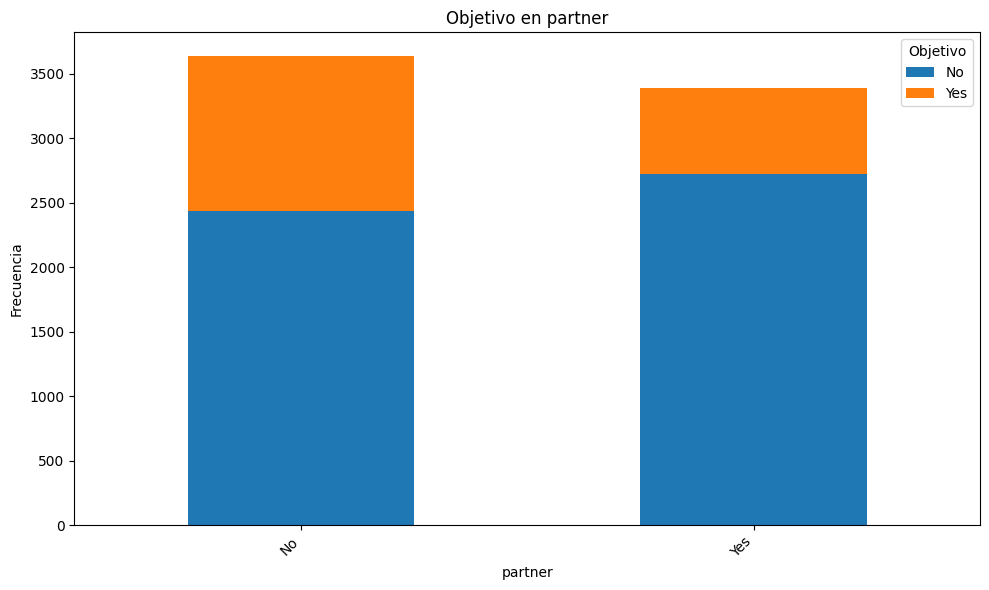

tabla de contingencia para dependents vs Objetivo:


end_date,No,Yes
dependents,,
No,3390,1543
Yes,1773,326


tabla de porcentaje para dependents vs Objetivo:


end_date,No,Yes
dependents,,
No,68.720860,31.279140
Yes,84.468795,15.531205


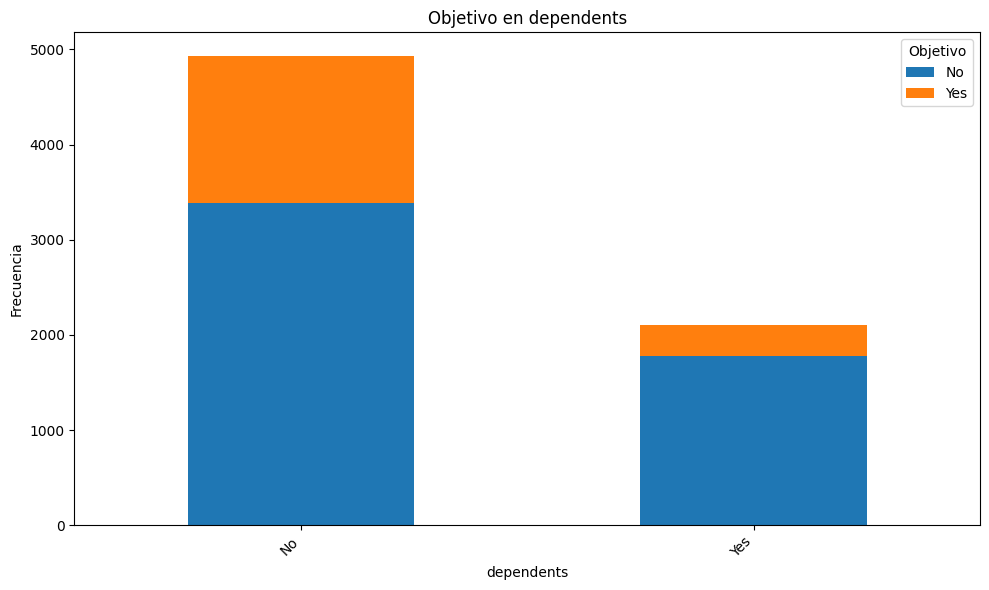

tabla de contingencia para internet_service vs Objetivo:


end_date,No,Yes
internet_service,,
DSL,1957,459
Fiber optic,1799,1297
No,1407,113


tabla de porcentaje para internet_service vs Objetivo:


end_date,No,Yes
internet_service,,
DSL,81.001656,18.998344
Fiber optic,58.107235,41.892765
No,92.565789,7.434211


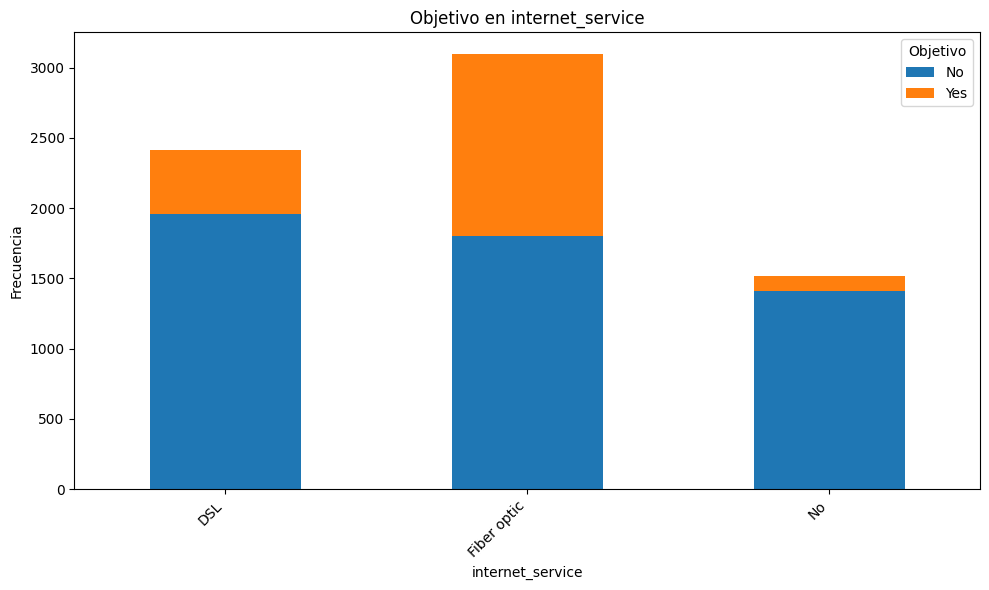

tabla de contingencia para online_security vs Objetivo:


end_date,No,Yes
online_security,,
No,3443,1574
Yes,1720,295


tabla de porcentaje para online_security vs Objetivo:


end_date,No,Yes
online_security,,
No,68.626669,31.373331
Yes,85.359801,14.640199


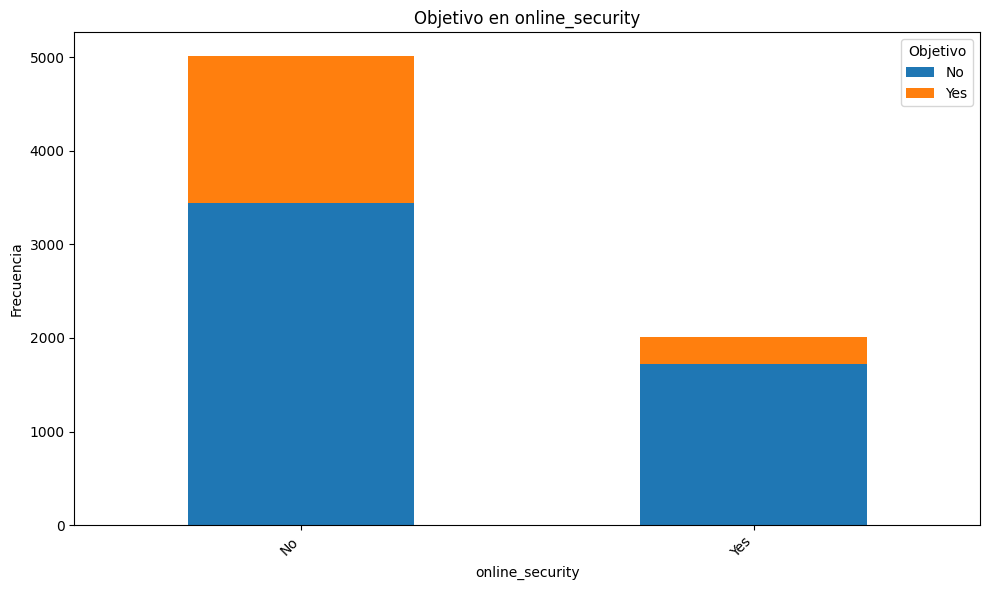

tabla de contingencia para online_backup vs Objetivo:


end_date,No,Yes
online_backup,,
No,3261,1346
Yes,1902,523


tabla de porcentaje para online_backup vs Objetivo:


end_date,No,Yes
online_backup,,
No,70.78359,29.21641
Yes,78.43299,21.56701


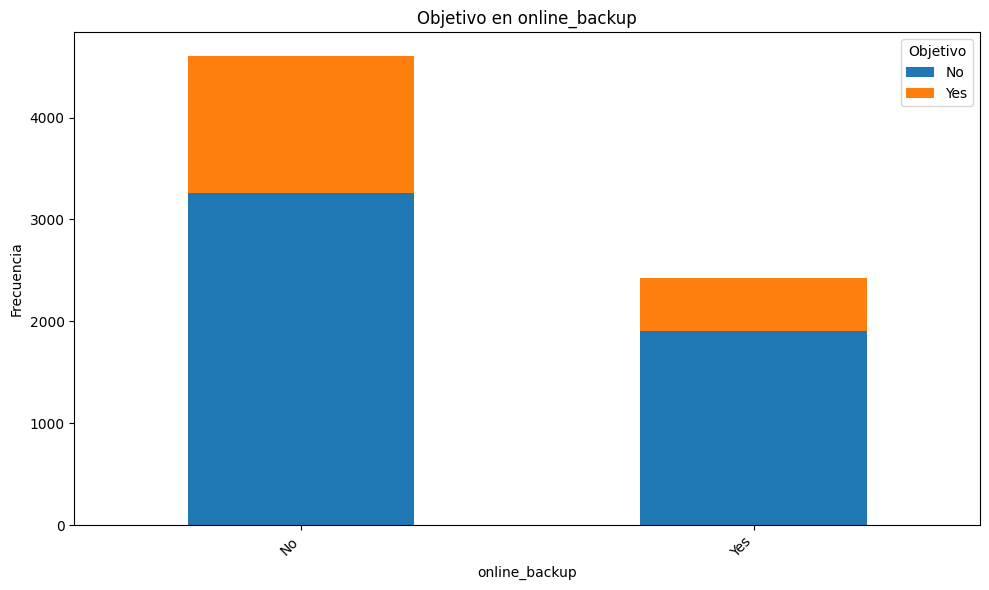

tabla de contingencia para device_protection vs Objetivo:


end_date,No,Yes
device_protection,,
No,3290,1324
Yes,1873,545


tabla de porcentaje para device_protection vs Objetivo:


end_date,No,Yes
device_protection,,
No,71.304725,28.695275
Yes,77.460711,22.539289


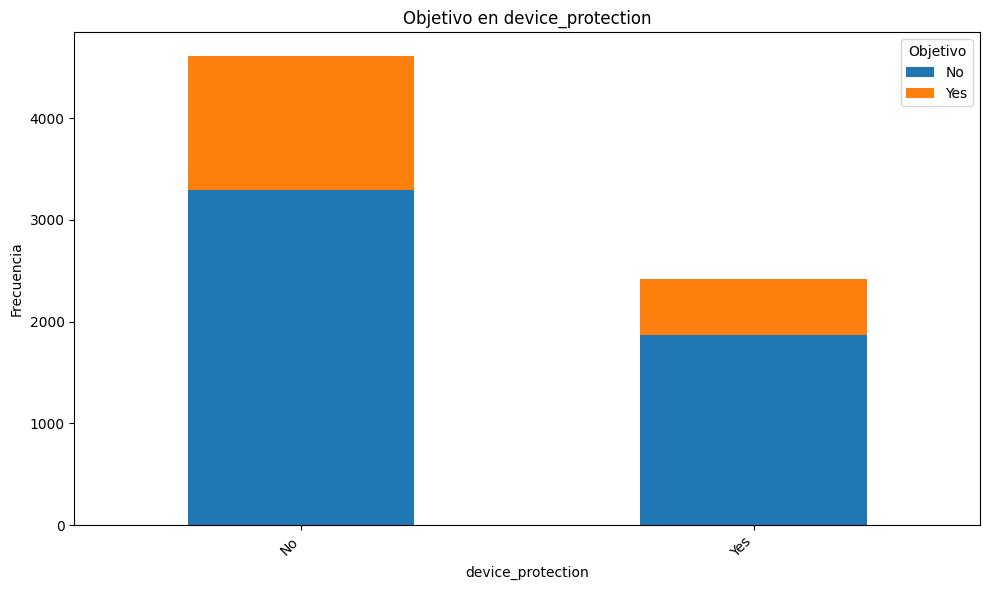

tabla de contingencia para tech_support vs Objetivo:


end_date,No,Yes
tech_support,,
No,3433,1559
Yes,1730,310


tabla de porcentaje para tech_support vs Objetivo:


end_date,No,Yes
tech_support,,
No,68.770032,31.229968
Yes,84.803922,15.196078


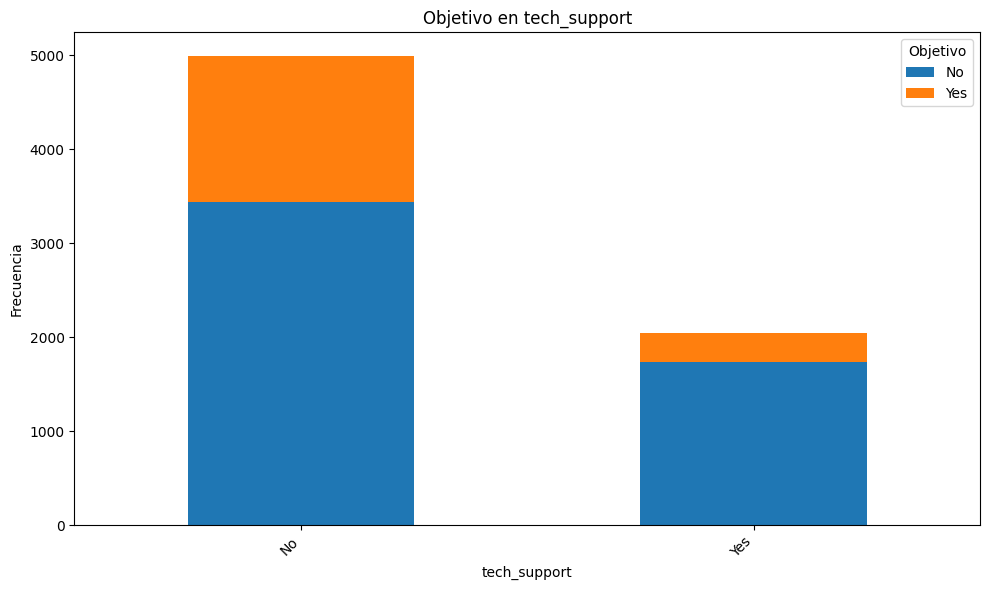

tabla de contingencia para streaming_tv vs Objetivo:


end_date,No,Yes
streaming_tv,,
No,3274,1055
Yes,1889,814


tabla de porcentaje para streaming_tv vs Objetivo:


end_date,No,Yes
streaming_tv,,
No,75.629476,24.370524
Yes,69.885313,30.114687


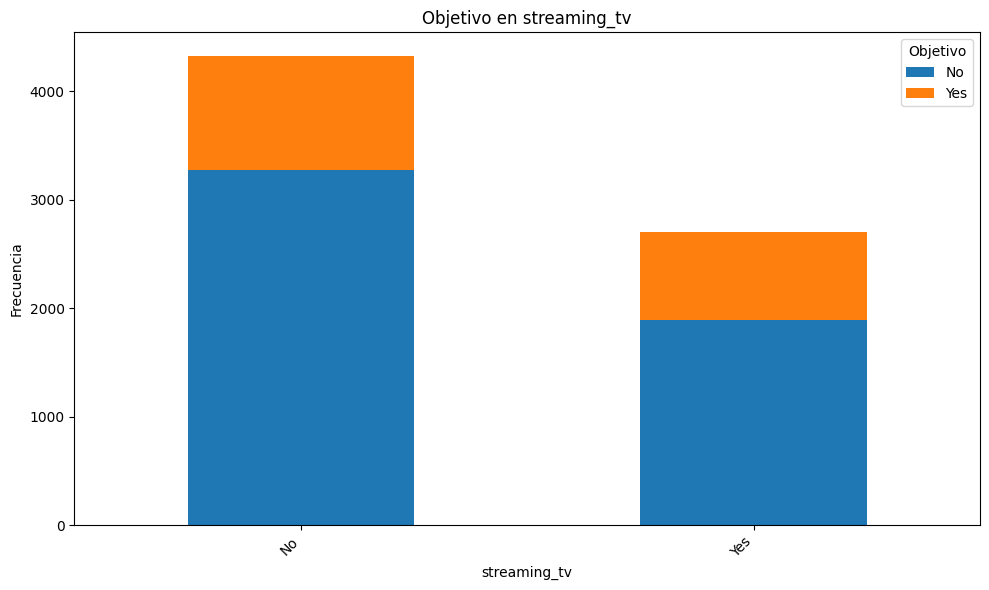

tabla de contingencia para streaming_movies vs Objetivo:


end_date,No,Yes
streaming_movies,,
No,3250,1051
Yes,1913,818


tabla de porcentaje para streaming_movies vs Objetivo:


end_date,No,Yes
streaming_movies,,
No,75.563822,24.436178
Yes,70.047602,29.952398


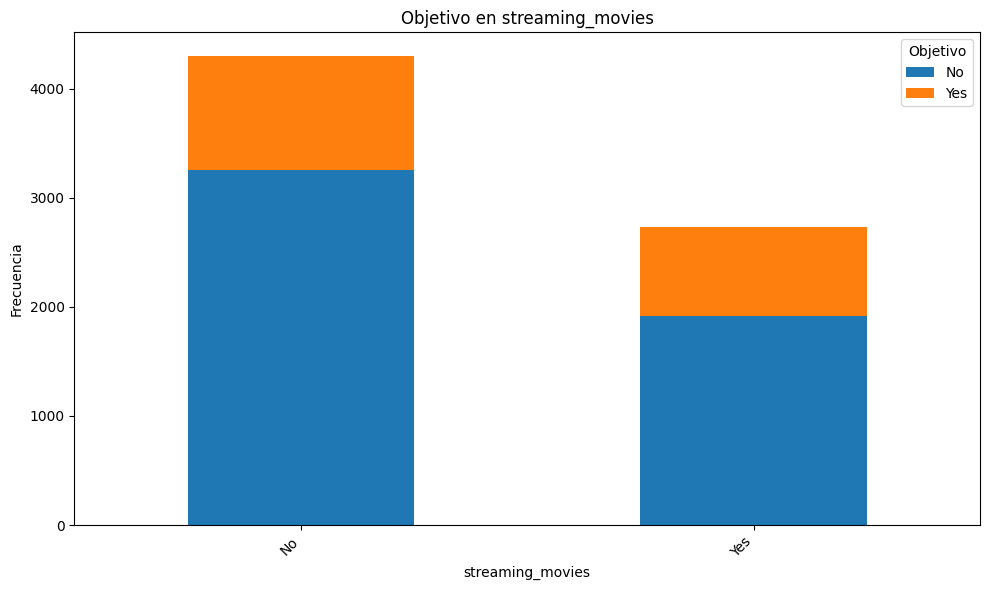

tabla de contingencia para multiple_lines vs Objetivo:


end_date,No,Yes
multiple_lines,,
No,3046,1019
Yes,2117,850


tabla de porcentaje para multiple_lines vs Objetivo:


end_date,No,Yes
multiple_lines,,
No,74.932349,25.067651
Yes,71.351534,28.648466


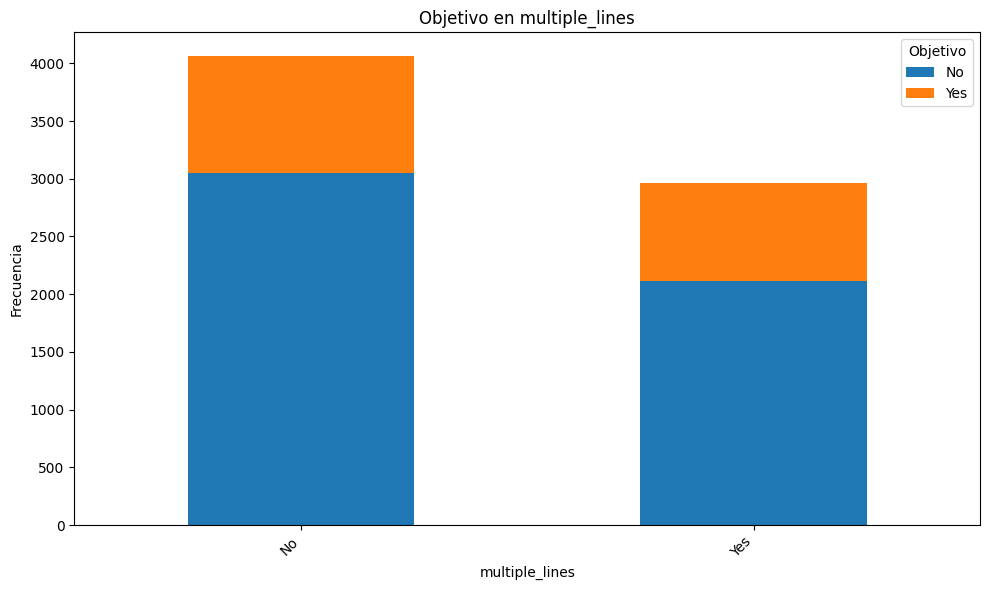

In [ ]:
categorical_cols = df_merged.select_dtypes(include='object').columns.tolist()
categorical_cols.remove('customer_id')
categorical_cols.remove('end_date')

for col in categorical_cols:
    # Create contingency table
    contingency_table = pd.crosstab(df_merged[col], df_merged['end_date'])

    # Calculate percentages
    contingency_percentage = contingency_table.div(contingency_table.sum(1), axis=0) * 100

    # Print tables
    print(f"tabla de contingencia para {col} vs Objetivo:")
    display(contingency_table)
    print(f"tabla de porcentaje para {col} vs Objetivo:")
    display(contingency_percentage)

    # Create stacked bar plot
    contingency_table.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.title(f'Objetivo en {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Objetivo')
    plt.tight_layout()
    plt.show()

Podemos notar con estos gráficos ciertos patrones de los clientes, algunos que parecen diferenciar bastante de los que cancelan a los que no, como puede ser el tipo de pago y el servicio de internet. asi que es momento de preparar nuestros datos para entrenar el modelo.



### 3. Entrenamiento del modelo.
Para comenzar tenemos que dividir los datos para entrenamiento, prueba y validación.


In [ ]:
#Eliminamos las columnas que no usaremos en el entrenamiento, y dividimos para el objetivo
X = df_merged.drop(['end_date', 'customer_id', 'begin_date'], axis=1)
y = df_merged['end_date']

# Dividiendo en 60% 20% y 20% respectivamente
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Dimensiones de los conjuntos de datos:")
print(f"Conjunto de entrenamiento (X_train, y_train): {X_train.shape}, {y_train.shape}")
print(f"Conjunto de validación (X_valid, y_valid): {X_valid.shape}, {y_valid.shape}")
print(f"Conjunto de prueba (X_test, y_test): {X_test.shape}, {y_test.shape}")

Dimensiones de los conjuntos de datos:
Conjunto de entrenamiento (X_train, y_train): (4219, 17), (4219,)
Conjunto de validación (X_valid, y_valid): (1406, 17), (1406,)
Conjunto de prueba (X_test, y_test): (1407, 17), (1407,)


In [ ]:
#Dividir las columnas
categorical_cols = X_train.select_dtypes(include='object').columns
numerical_cols = X_train.select_dtypes(include=np.number).columns

# Crear ColumnTransformer para las columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Entrenamos y procesamos
X_train_processed = preprocessing_pipeline.fit_transform(X_train)
X_valid_processed = preprocessing_pipeline.transform(X_valid)
X_test_processed = preprocessing_pipeline.transform(X_test)

print("Dimensiones de los conjuntos de datos después del preprocesamiento:")
print(f"Conjunto de entrenamiento (X_train_processed): {X_train_processed.shape}")
print(f"Conjunto de validación (X_valid_processed): {X_valid_processed.shape}")
print(f"Conjunto de prueba (X_test_processed): {X_test_processed.shape}")

Dimensiones de los conjuntos de datos después del preprocesamiento:
Conjunto de entrenamiento (X_train_processed): (4219, 35)
Conjunto de validación (X_valid_processed): (1406, 35)
Conjunto de prueba (X_test_processed): (1407, 35)


Teniendo divididos y procesados los datos, pasaremos a entrenar diferentes modelos para saber cual tiene mejor resultados con la metrica AUC-ROC como principal.

Evaluando: Logistic Regression

AUC-ROC: 0.8270
Accuracy (threshold 0.5): 0.7297
Precision: 0.4950
Recall: 0.7888
F1-Score: 0.6082

AUC-ROC (CV mean): 0.8393 (+/- 0.0261)
Evaluando: Random Forest

AUC-ROC: 0.7928
Accuracy (threshold 0.5): 0.7724
Precision: 0.6079
Recall: 0.4519
F1-Score: 0.5184

AUC-ROC (CV mean): 0.8261 (+/- 0.0283)
Evaluando: Gradient Boosting

AUC-ROC: 0.8335
Accuracy (threshold 0.5): 0.7831
Precision: 0.6202
Recall: 0.4759
F1-Score: 0.5386

AUC-ROC (CV mean): 0.8430 (+/- 0.0251)


<Figure size 1000x800 with 0 Axes>

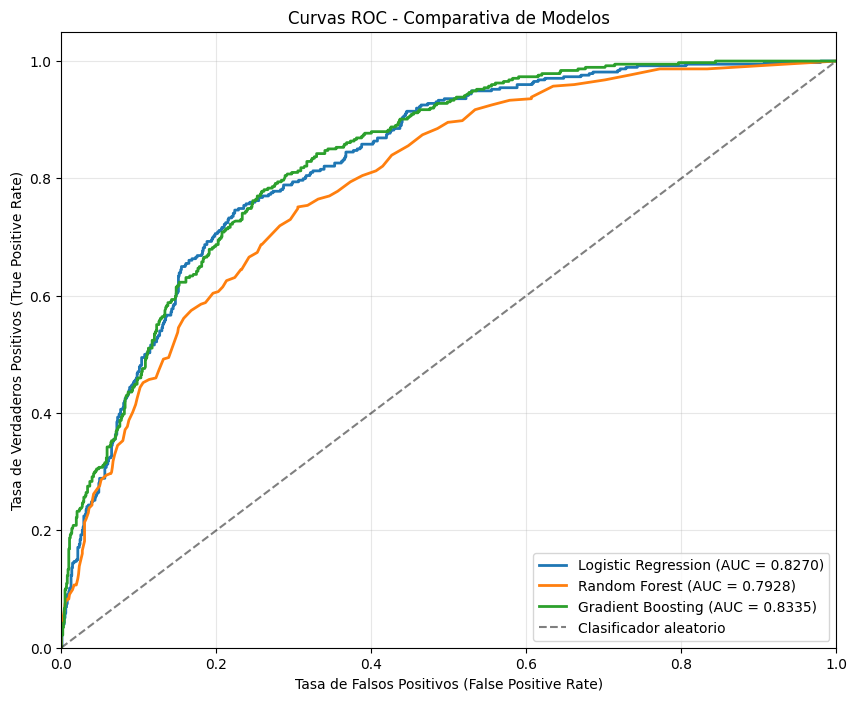

COMPARATIVA COMPLETA CON AUC-ROC
                Modelo  AUC-ROC  Accuracy (threshold 0.5)  Precision  Recall  \
0  Logistic Regression   0.8270                    0.7297     0.4950  0.7888   
1        Random Forest   0.7928                    0.7724     0.6079  0.4519   
2    Gradient Boosting   0.8335                    0.7831     0.6202  0.4759   

   F1-Score  Specificity     NPV   TP   FP   FN   TN  
0    0.6082       0.7083  0.9025  295  301   79  731  
1    0.5184       0.8944  0.8183  169  109  205  923  
2    0.5386       0.8944  0.8248  178  109  196  923  
MEJOR MODELO POR AUC-ROC: Gradient Boosting
AUC-ROC: 0.8335


In [ ]:
# Modelos a probar
models = {
    'Logistic Regression': LogisticRegression(
    class_weight='balanced',
    solver='liblinear',
    max_iter=1000,
    random_state=42
),
    'Random Forest': RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight='balanced',
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42
),
    'Gradient Boosting': GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    min_samples_split=2,
    min_samples_leaf=1,
    subsample=1.0,
    random_state=42)
}

# Map 'No' en 0 y 'Yes' en 1 para compatibilidad con AUC/ROC
y_train_numeric = y_train.map({'No': 0, 'Yes': 1})
y_valid_numeric = y_valid.map({'No': 0, 'Yes': 1})
y_test_numeric = y_test.map({'No': 0, 'Yes': 1})


# Función para evaluar AUC-ROC y métricas relacionadas
def evaluate_models_auc(models, X_train, X_valid, y_train_numeric, y_valid_numeric):
    """
    Evalúa modelos usando AUC-ROC y métricas complementarias
    """
    results = {}
    roc_data = {}

    plt.figure(figsize=(10, 8))

    for model_name, model in models.items():

        print(f"Evaluando: {model_name}")
        print()

        # Entrenar modelo
        model.fit(X_train, y_train)

        # Predecir probabilidades
        y_pred_proba = model.predict_proba(X_valid)[:, 1]
        y_pred = model.predict(X_valid)

        # Calcular AUC-ROC
        auc_roc = roc_auc_score(y_valid_numeric, y_pred_proba)

        # Calcular ROC curve
        fpr, tpr, thresholds = roc_curve(y_valid_numeric, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        accuracy = accuracy_score(y_valid_numeric, (y_pred_proba >= 0.5).astype(int))

        # Calculanfo precision, recall, f1, y confusion_matrix
        precision = precision_score(y_valid, y_pred, pos_label='Yes')
        recall = recall_score(y_valid, y_pred, pos_label='Yes')
        f1 = f1_score(y_valid, y_pred, pos_label='Yes')

        # Matriz de confusion
        cm = confusion_matrix(y_valid, y_pred, labels=['No', 'Yes'])


        # Guardar resultados
        results[model_name] = {
            'model': model,
            'auc_roc': auc_roc,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'confusion_matrix': cm,
            'y_pred_proba': y_pred_proba,
            'fpr': fpr,
            'tpr': tpr,
            'thresholds': thresholds
        }

        roc_data[model_name] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}

        # Mostrar métricas
        print(f"AUC-ROC: {auc_roc:.4f}")
        print(f"Accuracy (threshold 0.5): {accuracy:.4f}") # Indicate threshold used for accuracy
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print()

        # Cross-validation con AUC-ROC
        cv_auc = cross_val_score(model, X_train, y_train_numeric, cv=5, scoring='roc_auc') # Use numeric y for scoring
        print(f"AUC-ROC (CV mean): {cv_auc.mean():.4f} (+/- {cv_auc.std() * 2:.4f})")

    # Plot curva ROC comparativa
    plot_roc_curves(roc_data)

    return results, roc_data

def plot_roc_curves(roc_data):
    """
    Grafica las curvas ROC de todos los modelos
    """
    plt.figure(figsize=(10, 8))

    for model_name, data in roc_data.items():
        plt.plot(data['fpr'], data['tpr'],
                label=f'{model_name} (AUC = {data["auc"]:.4f})',
                linewidth=2)

    # Línea de referencia
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Clasificador aleatorio')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos (False Positive Rate)')
    plt.ylabel('Tasa de Verdaderos Positivos (True Positive Rate)')
    plt.title('Curvas ROC - Comparativa de Modelos')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()

# Evaluando los modelos con el set de validación
results, roc_data = evaluate_models_auc(models, X_train_processed, X_valid_processed, y_train_numeric, y_valid_numeric)

# Cuadro comparativo de las diferentes métricas
def create_auc_comparison(results):
    """
    Crea DataFrame comparativo con todas las métricas
    """
    comparison_data = []

    for model_name, result in results.items():
        # Calculate additional metrics from the confusion matrix (already using string labels with specified order)
        # cm = result['confusion_matrix'] # Already calculated with labels=['No', 'Yes']
        tn, fp, fn, tp = result['confusion_matrix'].ravel()

        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Specificity
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value

        comparison_data.append({
            'Modelo': model_name,
            'AUC-ROC': result['auc_roc'],
            'Accuracy (threshold 0.5)': result['accuracy'], # Label with threshold used
            'Precision': result['precision'],
            'Recall': result['recall'],
            'F1-Score': result['f1_score'],
            'Specificity': specificity,
            'NPV': npv,
            'TP': tp,
            'FP': fp,
            'FN': fn,
            'TN': tn
        })

    return pd.DataFrame(comparison_data)

# Mostrar comparación detallada
auc_comparison = create_auc_comparison(results)

print("COMPARATIVA COMPLETA CON AUC-ROC")

print(auc_comparison.round(4))

# Encontrar mejor modelo por AUC-ROC
best_auc_model = auc_comparison.loc[auc_comparison['AUC-ROC'].idxmax()]

print(f"MEJOR MODELO POR AUC-ROC: {best_auc_model['Modelo']}")
print(f"AUC-ROC: {best_auc_model['AUC-ROC']:.4f}")





### 4. Prueba del modelo.

El modelo que mejor puntaje tuvo fue el GradientBoosting por lo que lo probaremos con el

In [ ]:
#Entrenamos el modelo para su prueba
model_gradient = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    min_samples_split=2,
    min_samples_leaf=1,
    subsample=1.0,
    random_state=42)

model_gradient.fit(X_train_processed, y_train)

#Probamos el modelo con distintas metricas
score = model_gradient.score(X_test_processed, y_test)
cm = confusion_matrix(y_test, model_gradient.predict(X_test_processed), labels=['No', 'Yes'])
f1_test = f1_score(y_test, model_gradient.predict(X_test_processed), pos_label='Yes')
precision_test = precision_score(y_test, model_gradient.predict(X_test_processed), pos_label='Yes')
recall_test = recall_score(y_test, model_gradient.predict(X_test_processed), pos_label='Yes')
accuracy_test = accuracy_score(y_test, model_gradient.predict(X_test_processed))

print('Puntajes en el conjunto de prueba:')
print(f"Accuracy: {accuracy_test:.4f}")
print(f"F1-Score: {f1_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print("\nMatriz de confusión:")
print(cm)

Puntajes en el conjunto de prueba:
Accuracy: 0.7889
F1-Score: 0.5664
Precision: 0.6238
Recall: 0.5187

Matriz de confusión:
[[916 117]
 [180 194]]


El modelo acierta en clasificar si la persona se va a cancelar su plan o no, un 80 % de las veces. Como podemos observar en nuestra matriz de confusión:

VP: 916 (Detecta que no cancelan correctamente)

FP: 117 (Detecta que no cancelan, pero si lo hacen)

FN: 180 (Detecta que si cancelan, pero no lo hacen)

VN: 194 (Detecta que si cancelan correctamente)

##Conclusión

Con los resultados obtenidos en el dataset de prueba al 25% de los usuarios se les mandaran promocionales para intentar que no cancelen su plan.

El modelo clasifica mejor los usuarios que no cancelaran su cuenta, identificando a estos la empresa ahorra en no mandar tantos promocionales que pueden costarles.

Los datos proporcionados son pocos y con un desequilibrio notable, pero se logro cumplir el objetivo de tener un AUC-ROC aproximadamente de 80% para sesgar a los usuarios y que no se retiren del plan que tienen.
